In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 180

ng =3

ng_refs = (/ 3 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 800

data w_diffuse
     &     /1.66 , 1.66 , 1.85/

data wgt
     &     /0.5 , 0.55 , 0.85/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

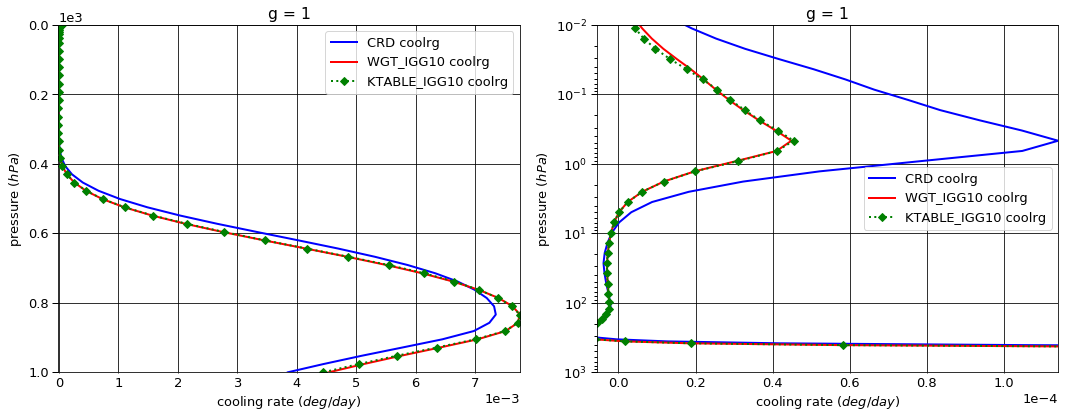

# Figure: cooling rate g-group 2

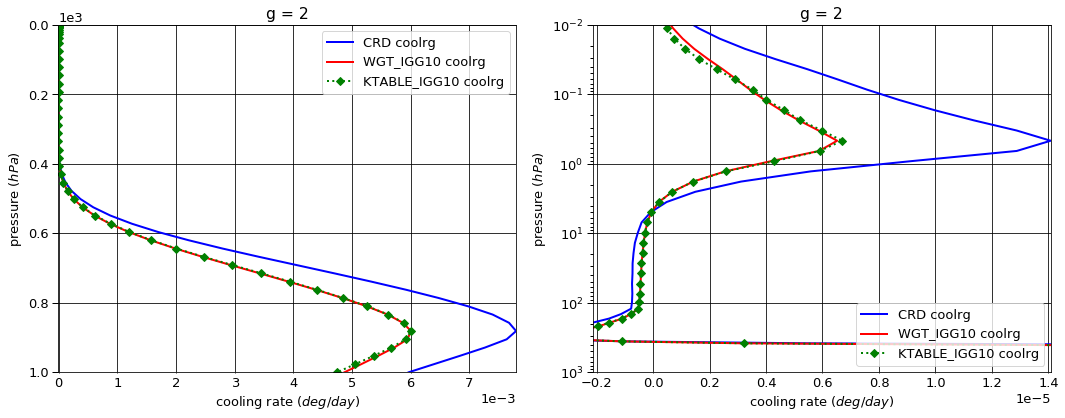

# Figure: cooling rate g-group 3

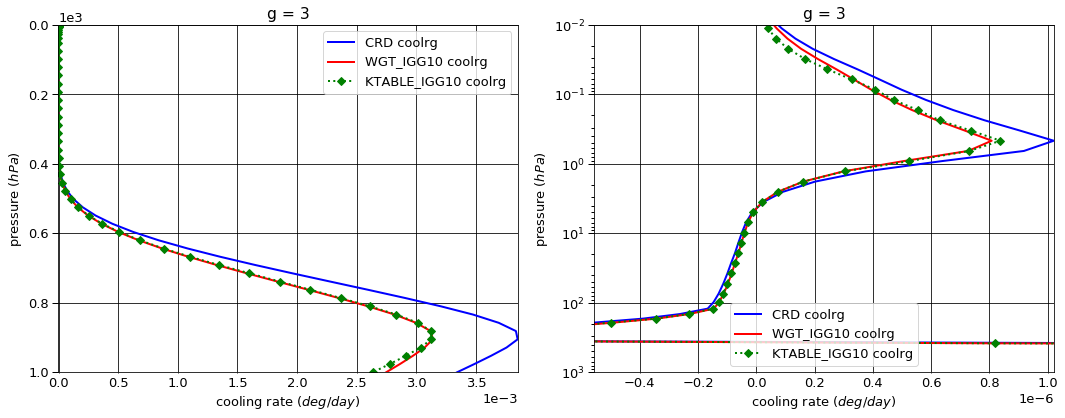

# Figure: cooling rate g-group total

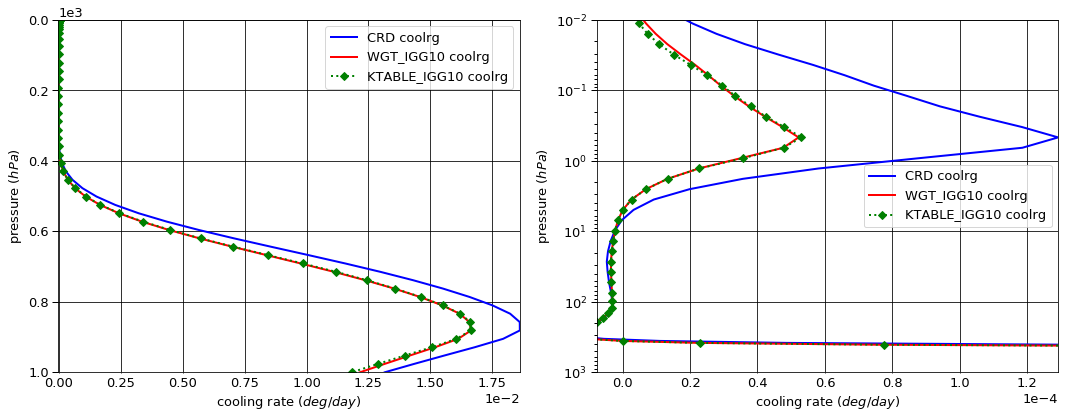

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.660363  0.000000  -0.660363
  1013.0   76     -0.685307  0.344714  -0.340593
2 0.0      1      -2.846556  0.000000  -2.846556
  1013.0   76     -2.856831  0.303276  -2.553556
3 0.0      1     -29.318357  0.000000 -29.318357
  1013.0   76    -29.321628  0.140677 -29.180951


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.665612  0.000000  -0.665612
  1013.0   76     -0.685307  0.340013  -0.345293
2 0.0      1      -2.849835  0.000000  -2.849835
  1013.0   76     -2.856832  0.229451  -2.627381
3 0.0      1     -29.318977  0.000000 -29.318977
  1013.0   76    -29.321628  0.114208 -29.207420


KTABLE_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.665428  0.000000  -0.665428
  1013.0   76     -0.685307  0.339817  -0.345490
2 0.0      1      -2.849709  0.000000  -2.849709
  1013.0   76     -2.856832  0.229164  -2.627668
3 0.0      1     -29.318899  0.000000 -29.318899
  1013.0   76    -29.321628  0.113997 -29.207631


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.249600e-03  0.000000 -0.005250
  1013.0   76     0.000000e+00 -0.004701 -0.004701
2 0.0      1     -3.278500e-03  0.000000 -0.003278
  1013.0   76    -4.440892e-16 -0.073825 -0.073825
3 0.0      1     -6.200000e-04  0.000000 -0.000620
  1013.0   76     0.000000e+00 -0.026469 -0.026469


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.065260e-03  0.000000 -0.005065
  1013.0   76     0.000000e+00 -0.004897 -0.004897
2 0.0      1     -3.152700e-03  0.000000 -0.003153
  1013.0   76    -4.440892e-16 -0.074112 -0.074112
3 0.0      1     -5.420000e-04  0.000000 -0.000542
  1013.0   76     0.000000e+00 -0.026680 -0.026680

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.627515e-06
  1001.112500 75     3.848974e-03
2 0.000312    1     -9.575540e-07
  1001.112500 75     5.964491e-03
3 0.000312    1     -5.081850e-08
  1001.112500 75     3.341759e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.891486e-06
  1001.112500 75     4.537762e-03
2 0.000312    1     -4.703173e-07
  1001.112500 75     4.870861e-03
3 0.000312    1     -3.938674e-08
  1001.112500 75     2.747453e-03


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.778743e-06
  1001.112500 75     4.444844e-03
2 0.000312    1     -3.336825e-07
  1001.112500 75     4.744767e-03
3 0.000312    1     -1.786813e-08
  1001.112500 75     2.634758e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.736029e-06
  1001.112500 75     6.887884e-04
2 0.000312    1      4.872368e-07
  1001.112500 75    -1.093630e-03
3 0.000312    1      1.143176e-08
  1001.112500 75    -5.943052e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.848772e-06
  1001.112500 75     5.958697e-04
2 0.000312    1      6.238715e-07
  1001.112500 75    -1.219724e-03
3 0.000312    1      3.295037e-08
  1001.112500 75    -7.070009e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.825276,0.000000,-32.825276
1013.0,76,-32.863766,0.788667,-32.075099



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.834424,0.000000,-32.834424
1013.0,76,-32.863766,0.683673,-32.180094



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.834036,0.000000,-32.834036
1013.0,76,-32.863766,0.682978,-32.180789



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.009148,0.000000,-0.009148
1013.0,76,0.000000,-0.104995,-0.104995



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.00876,0.000000,-0.00876
1013.0,76,0.00000,-0.105689,-0.10569


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.013155



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.012156



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.011824



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,-0.000999



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000004
1001.112500,75,-0.001331


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     1.621090e-23  5.426360e-25   29.874351  7.133751e-10
      2 0.000312     5.032652e-25  1.371556e-26   36.693014  2.409787e-11
      3 0.000312     2.315043e-27  2.501890e-29   92.531763  1.678985e-13
2     1 0.000750     1.689336e-23  5.492098e-25   30.759395  2.991556e-10
      2 0.000750     5.201294e-25  1.390761e-26   37.398916  1.002742e-11
      3 0.000750     2.435237e-27  2.560873e-29   95.094007  7.113477e-14
3     1 0.001052     1.836056e-23  5.621171e-25   32.663235  4.551313e-10
      2 0.001052     5.569294e-25  1.428082e-26   38.998430  1.504403e-11
      3 0.001052     2.699190e-27  2.676802e-29  100.836370  1.105594e-13
4     1 0.001476     1.997536e-23  5.749754e-25   34.741242  6.934214e-10
      2 0.001476     5.983165e-25  1.464769e-26   40.847158  2.265244e-11
      3 0.001476     2.998506e-27  2.799824e-29  107.096260  1.722849e-13
5     1 0.002070     2.173041e-23  5.876547e-25   36.978186  1.056245e-09
      2 0.002070     6.443993e-25  1.500924e-26   42.933506  3.418647e-11
      3 0.002070     3.334229e-27  2.930053e-29  113.794160  2.686739e-13
6     1 0.002904     2.363676e-23  6.001659e-25   39.383719  1.609023e-09
      2 0.002904     6.957935e-25  1.537301e-26   45.260722  5.172950e-11
      3 0.002904     3.711125e-27  3.069551e-29  120.901240  4.194426e-13
7     1 0.004074     2.570630e-23  6.125123e-25   41.968618  2.450972e-09
      2 0.004074     7.531904e-25  1.574710e-26   47.830426  7.847580e-11
      3 0.004074     4.134647e-27  3.221179e-29  128.358200  6.554750e-13
8     1 0.005714     2.795204e-23  6.247107e-25   44.743972  3.732876e-09
      2 0.005714     8.173745e-25  1.613917e-26   50.645388  1.193451e-10
      3 0.005714     4.611110e-27  3.388996e-29  136.061230  1.025293e-12
9     1 0.008015     3.038732e-23  6.368137e-25   47.717752  5.684598e-09
      2 0.008015     8.892052e-25  1.655610e-26   53.708625  1.819537e-10
      3 0.008015     5.147626e-27  3.578783e-29  143.837320  1.605419e-12
10    1 0.011243     3.302700e-23  6.489537e-25   50.892686  8.655319e-09
      2 0.011243     9.696599e-25  1.700511e-26   57.021660  2.780754e-10
      3 0.011243     5.752504e-27  3.799032e-29  151.420230  2.516372e-12
11    1 0.015771     3.588643e-23  6.613883e-25   54.259254  1.317634e-08
      2 0.015771     1.059811e-24  1.749563e-26   60.575788  4.259721e-10
      3 0.015771     6.435186e-27  4.062357e-29  158.410150  3.948452e-12
12    1 0.022122     3.898187e-23  6.745645e-25   57.788208  2.005462e-08
      2 0.022122     1.160846e-24  1.804200e-26   64.341322  6.539671e-10
      3 0.022122     7.206527e-27  4.387765e-29  164.241390  6.202147e-12
13    1 0.031031     4.231506e-23  6.891496e-25   61.401846  3.050567e-08
      2 0.031031     1.273541e-24  1.866481e-26   68.232192  1.005662e-09
      3 0.031031     8.074933e-27  4.802948e-29  168.124510  9.747945e-12
14    1 0.043528     4.548420e-23  7.050883e-25   64.508516  4.595977e-08
      2 0.043528     1.384300e-24  1.934209e-26   71.569332  1.532485e-09
      3 0.043528     8.937807e-27  5.322505e-29  167.924820  1.513466e-11
15    1 0.061057     4.807788e-23  7.227252e-25   66.523035  6.811334e-08
      2 0.061057     1.477404e-24  2.006274e-26   73.639166  2.293494e-09
      3 0.061057     9.672710e-27  5.966697e-29  162.111640  2.297612e-11
16    1 0.085645     5.042468e-23  7.445867e-25   67.721712  1.001802e-07
      2 0.085645     1.563437e-24  2.092686e-26   74.709575  3.403894e-09
      3 0.085645     1.036147e-26  6.816458e-29  152.006670  3.452605e-11
17    1 0.120136     5.286441e-23  7.737390e-25   68.323312  1.473041e-07
      2 0.120136     1.654633e-24  2.205970e-26   75.007035  5.052973e-09
      3 0.120136     1.110220e-26  7.985080e-29  139.036750  5.189789e-11
18    1 0.168516     5.540918e-23  8.131395e-25   68.142276  2.165814e-07
      2 0.168516     1.751558e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
